In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
import csv

In [2]:
from data_setup import copy_images_to_folders, create_folders, remove_folders, split_data_for_class, split_data
from image_check import imshow
from model import CustomEfficientNetB0, CustomLoss, compute_class_weights, normalize_matrix, print_matrix, validate_model, train_model, plot_metrics, visualize_model
from uncertainty_metrics import export_to_csv, calculate_risks, process_labels, calculate_and_append_risks, calculate_and_append_risks_by_class, calculate_softmax_uncertainties, calculate_top2_softmax_uncertainties, calculate_random_uncertainties, calculate_mc_dropout_uncertainties_by_sample, calculate_mc_dropout_uncertainties_by_class, calculate_variance_uncertainties, calculate_variational_ratio_uncertainties, calculate_entropy_uncertainties, calculate_predictive_entropy_uncertainties, calculate_mutual_information_uncertainties, smooth_calcs, calculate_aurc, plot_risk_coverage, process_uncertainties, calculate_variational_ratio_dropout_uncertainties, calculate_mutual_information_mc_dropout, select_desired_metrics

In [3]:
# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [4]:
# Constants
CSV_PATH = 'data/ISIC_2019_Training_GroundTruth.csv'
IMAGE_FOLDER = 'data/ISIC_2019_Resized'
SORTED_FOLDER = 'data/ISIC_Sorted'
SUBSET_FOLDER = 'data/data_subset'
SAMPLE_LIMIT = None  # None or a number up to 12875
TRAIN_RATIO = 0.6
VAL_RATIO = 0.1
TEST_RATIO = 0.3
SET_BATCH_SIZE = 64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

In [ ]:
# Validation for ratios
if TRAIN_RATIO + VAL_RATIO + TEST_RATIO != 1:
    print("Invalid data ratios")
else:
    print("Data ratios are valid")

    # Perform operations
    copy_images_to_folders(CSV_PATH, IMAGE_FOLDER, SORTED_FOLDER)
    print("images split into classes")
    
    remove_folders(os.path.join(SUBSET_FOLDER, 'train'), os.path.join(SUBSET_FOLDER, 'val'), os.path.join(SUBSET_FOLDER, 'test'))
    
    split_data(SORTED_FOLDER, os.path.join(SUBSET_FOLDER, 'train'), os.path.join(SUBSET_FOLDER, 'val'), os.path.join(SUBSET_FOLDER, 'test'), train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO, test_ratio=TEST_RATIO, sample_limit=SAMPLE_LIMIT, seed=6861611)
    print("data split into train, validation and test sets for each class")
    
    # Remove unknown folder as there are no samples
    remove_folders(os.path.join(SUBSET_FOLDER, 'train', 'UNK'), os.path.join(SUBSET_FOLDER, 'val', 'UNK'), os.path.join(SUBSET_FOLDER, 'test', 'UNK'))
    print("UNK folders removed")

In [5]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=360),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [6]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(SUBSET_FOLDER, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=SET_BATCH_SIZE, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Adjusted way to obtain class names
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


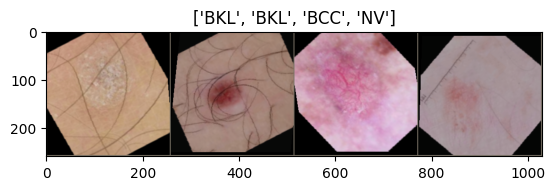

In [7]:
# Specify the number of images to display
num_images = 4

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Select a subset of images
inputs_subset = inputs[:num_images]
classes_subset = classes[:num_images]

# Make a grid from the subset
out = torchvision.utils.make_grid(inputs_subset)

imshow(out, title=[class_names[x] for x in classes_subset])

In [8]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [9]:
# Convert targets to tensor and move to device
targets_tensor = torch.tensor(image_datasets['train'].targets).to(device)

# Compute class weights
no_weights = None
custom_weights = torch.FloatTensor(np.divide([82, 112, 52, 52, 481, 52, 481, 82], 40)).to(device)
equal_weights = torch.FloatTensor(compute_class_weights(targets_tensor, len(image_datasets['train'].classes))).to(device)
#equal_custom_weights = (equal_weights * custom_weights).to(device)
weight_balance = 0.5
equal_custom_weights = torch.sqrt(weight_balance * custom_weights * equal_weights)

weights = [no_weights, custom_weights, equal_weights, equal_custom_weights]

# Print class weights
print("Base Weights:", weights[0])
print("Custom Weights:", weights[1])
print("Equal Weights:", weights[2])
print("Equal Custom Weights:", weights[3])
print()

save_dirs = ["no_class_weights", "custom_weights", "equal_weights", "equal_custom_weights"]

Base Weights: None
Custom Weights: tensor([ 2.0500,  2.8000,  1.3000,  1.3000, 12.0250,  1.3000, 12.0250,  2.0500],
       device='cuda:0')
Equal Weights: tensor([ 3.6526,  0.9530,  1.2067, 13.2823,  0.7001,  0.2459,  5.0515, 12.5786],
       device='cuda:0')
Equal Custom Weights: tensor([1.9349, 1.1551, 0.8856, 2.9383, 2.0517, 0.3998, 5.5111, 3.5907],
       device='cuda:0')



In [10]:
weights_index = 3

In [11]:
# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.4).to(device)

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss(weight=(weights[weights_index]), reduction='mean').to(device)

Loaded pretrained weights for efficientnet-b0


In [12]:
num_val_mc_samples=100

In [13]:
num_epochs = 50

train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device,
    num_epochs=num_epochs, num_val_mc_samples=num_val_mc_samples, loss_weight=1, acc_weight=0, num_classes=num_classes,
    save_dir=save_dirs[weights_index], restart_training=False)

Best combined metric: -0.4828
Loss associated with the best combined metric: 0.4828
Accuracy associated with the best combined metric: 0.8604
Epoch associated with the best model: 47



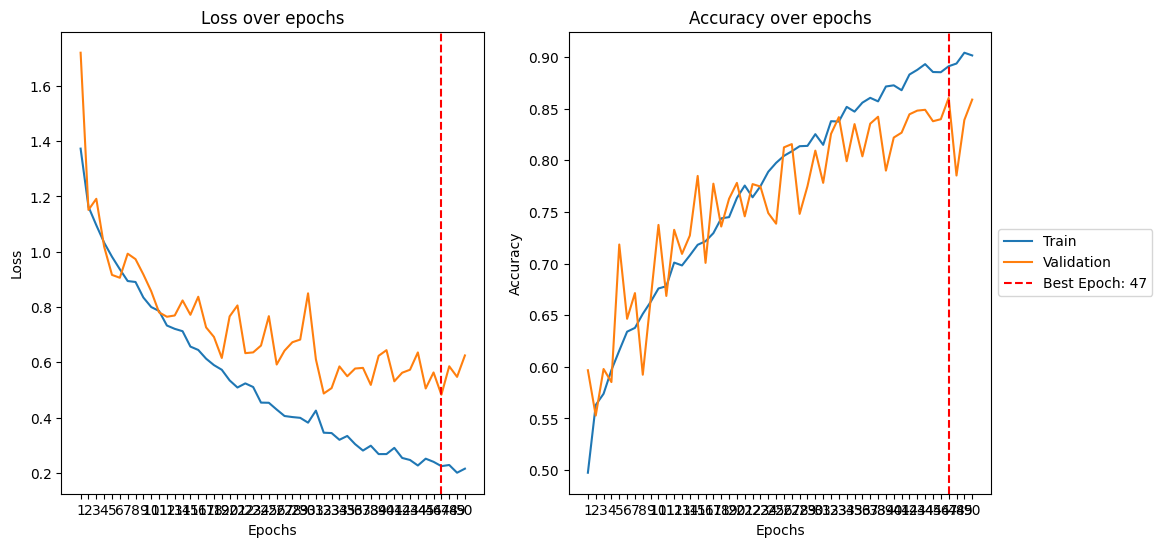

In [14]:
# Load the checkpoint
checkpoint = torch.load(os.path.join(save_dirs[weights_index], 'checkpoint.pth.tar'))

# Load model state_dict
model_ft.load_state_dict(checkpoint['model_state_dict'])

# Load optimizer state_dict
optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

# Load scheduler state_dict
exp_lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Retrieve other variables
best_combined_metric = checkpoint['best_combined_metric']
best_val_loss = checkpoint['best_val_loss']
best_val_acc = checkpoint['best_val_acc']
best_epoch = checkpoint['best_epoch']
train_losses = checkpoint['train_losses']
train_accuracies = checkpoint['train_accuracies']
val_losses = checkpoint['val_losses']
val_accuracies = checkpoint['val_accuracies']

plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)

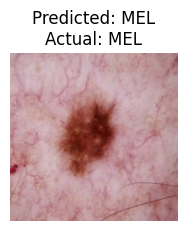

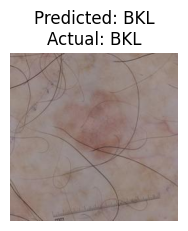

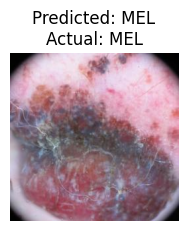

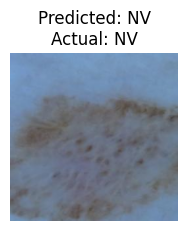

In [15]:
visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)

In [16]:
uncertainty_functions = [
    (calculate_softmax_uncertainties, "Softmax Response"),
    (calculate_top2_softmax_uncertainties, "Top2 Softmax Difference"),
    (calculate_random_uncertainties, "Random Uncertainties"),
    (calculate_mc_dropout_uncertainties_by_sample, "MCD By Sample", {"num_samples": num_val_mc_samples}),
    (calculate_mc_dropout_uncertainties_by_class, "MCD By Class", {"num_samples": num_val_mc_samples}),
    (calculate_variance_uncertainties, "Variance"),
    (calculate_variational_ratio_uncertainties, "Variational Ratio"),
    (calculate_variational_ratio_dropout_uncertainties, "Variational Ratio with Dropout", {"num_samples": num_val_mc_samples}),
    (calculate_entropy_uncertainties, "Entropy"),
    (calculate_predictive_entropy_uncertainties, "Predictive Entropy", {"num_samples": num_val_mc_samples}),
    (calculate_mutual_information_uncertainties, "Mutual Information"),
    (calculate_mutual_information_mc_dropout, "Mutual Information with Dropout", {"num_samples": num_val_mc_samples})
]

In [17]:
cost_matrix = [
    [0,     1,	    20,	    20,	    10,	    20,	    10,	    1],
    [1,	    0,	    30,	    30,	    10,	    30,	    10,	    1],
    [10,	10,	    0,	    1,	    10,	    1,	    10,	    10],
    [10,	10,	    1,	    0,	    10,	    1,	    10,	    10],
    [10,    10,	    150,	150,	0,	    150,	1,	    10],
    [10,	10,	    1,	    1,	    10,	    0,	    10,	    10],
    [10,	10,	    150,	150,	1,	    150,	0,      10],
    [1,	    1,	    20,	    20,	    10,	    20,	    10,	    0]
]

In [18]:
# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

for function, name, *args in uncertainty_functions:
    if args:  # Check if additional arguments exist
        additional_args = args[0]  # Extract additional arguments
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name, cost_matrix, **additional_args)  # Pass additional arguments as keyword arguments
    else:
        process_uncertainties(risks_list, labels_list, risks_list_by_class, labels_list_by_class, model_ft, dataloaders['test'], class_names, device, function, name, cost_matrix)

Softmax Response processed
Top2 Softmax Difference processed
Random Uncertainties processed
2024-04-07 22:02:11.782697 - Batch 1/119 processed
2024-04-07 22:02:22.763091 - Batch 2/119 processed
2024-04-07 22:02:34.158650 - Batch 3/119 processed
2024-04-07 22:02:45.001511 - Batch 4/119 processed
2024-04-07 22:02:55.874666 - Batch 5/119 processed
2024-04-07 22:03:06.739679 - Batch 6/119 processed
2024-04-07 22:03:17.609996 - Batch 7/119 processed
2024-04-07 22:03:28.478499 - Batch 8/119 processed
2024-04-07 22:03:39.330550 - Batch 9/119 processed
2024-04-07 22:03:50.182560 - Batch 10/119 processed
2024-04-07 22:04:01.062116 - Batch 11/119 processed
2024-04-07 22:04:11.948410 - Batch 12/119 processed
2024-04-07 22:04:22.804969 - Batch 13/119 processed
2024-04-07 22:04:33.665645 - Batch 14/119 processed
2024-04-07 22:04:44.521528 - Batch 15/119 processed
2024-04-07 22:04:55.387785 - Batch 16/119 processed
2024-04-07 22:05:06.254537 - Batch 17/119 processed
2024-04-07 22:05:17.123208 - Batc

In [19]:
torch.save(risks_list, os.path.join(save_dirs[weights_index], 'risks_list.pth'))
torch.save(labels_list, os.path.join(save_dirs[weights_index], 'labels_list.pth'))
torch.save(risks_list_by_class, os.path.join(save_dirs[weights_index], 'risks_list_by_class.pth'))
torch.save(labels_list_by_class, os.path.join(save_dirs[weights_index], 'labels_list_by_class.pth'))

In [20]:
risks_list = torch.load(os.path.join(save_dirs[weights_index], 'risks_list.pth'))
labels_list = torch.load(os.path.join(save_dirs[weights_index], 'labels_list.pth'))
risks_list_by_class = torch.load(os.path.join(save_dirs[weights_index], 'risks_list_by_class.pth'))
labels_list_by_class = torch.load(os.path.join(save_dirs[weights_index], 'labels_list_by_class.pth'))

In [21]:
# Define the desired metrics to plot
# comment out undesired metrics
desired_metrics = [
    "Softmax Response",
    "Top2 Softmax Difference",
    "Random Uncertainties",
    "MCD By Sample",
    "MCD By Class",
    "Variance",
    "Variational Ratio",
    "Variational Ratio with Dropout",
    "Entropy",
    "Predictive Entropy",
    "Mutual Information",
    "Mutual Information with Dropout"
]

All Classes: 7595 samples

AURC (full):
Label                          	AURC
----------------------------------------------
Predictive Entropy                  	0.00722443376035702
MCD By Sample                       	0.007235572001939999
Variance                            	0.007241470599527374
Softmax Response                    	0.007264448562746653
Top2 Softmax Difference             	0.007313250911217221
Variational Ratio                   	0.007380526640056281
Variational Ratio with Dropout      	0.007382208063825676
Entropy                             	0.0077916885325198006
MCD By Class                        	0.008231280611090509
Mutual Information                  	0.009524286018436797
Mutual Information with Dropout     	0.009555438039223504
Random Uncertainties                	0.023770558553008744

AURC (20% cutoff):
Label                          	AURC
----------------------------------------------
MCD By Sample                       	0.00708329897947329
Predictive Entropy 

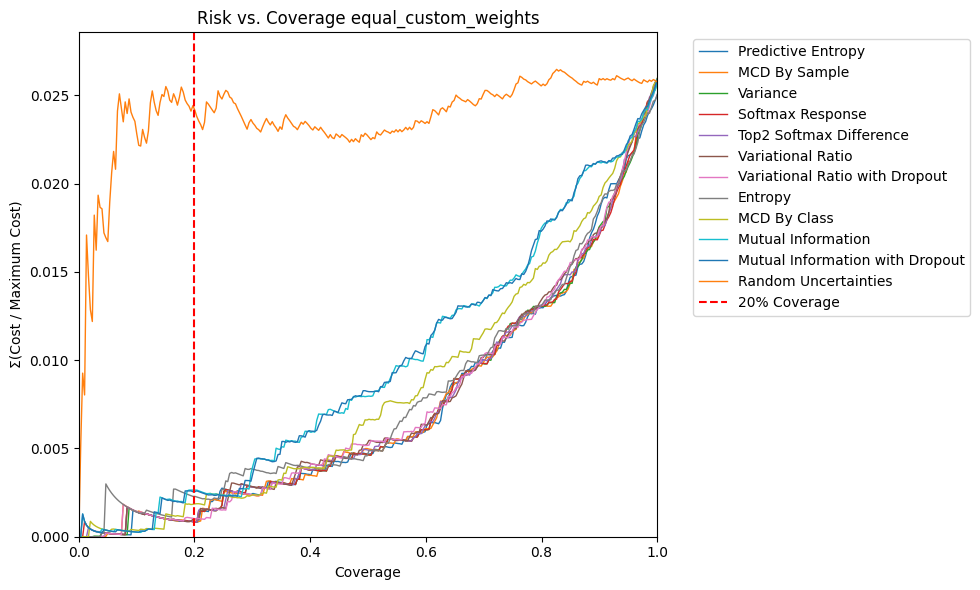

In [22]:
# Select desired metrics for all samples
selected_labels_list, selected_risks_list = select_desired_metrics(labels_list, risks_list, desired_metrics)

# Print information about all classes
print(f"All Classes: {len(selected_risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list[0])
aurc_full_list, aurc_cuttoff_list = calculate_aurc(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage)
export_to_csv(aurc_full_list, os.path.join(save_dirs[weights_index], 'aurc_full_list.csv'))
export_to_csv(aurc_cuttoff_list, os.path.join(save_dirs[weights_index], 'aurc_cuttoff_list.csv'))
plot_risk_coverage(selected_risks_list, selected_labels_list, x_smooth_percentage_interp, x_smooth_percentage, save_dirs[weights_index])

print()

In [ ]:
# Iterate over each class
for i in range(len(class_names)):
    # Select desired metrics for the current class
    selected_labels_list_class, selected_risks_list_class = select_desired_metrics(labels_list_by_class[i], risks_list_by_class[i], desired_metrics)
    
    # Print information about the current class
    print(f"{class_names[i]}: {len(selected_risks_list_class[0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(selected_risks_list_class[0])
    calculate_aurc(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    plot_risk_coverage(selected_risks_list_class, selected_labels_list_class, x_smooth_percentage_interp, x_smooth_percentage)
    print()

In [ ]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print(
"""
- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.
- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.
- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.

- Classes:
    - Melanoma (MEL)
    - Melanocytic nevus (NV)
    - Basal cell carcinoma (BCC)
    - Actinic keratosis (AK)
    - Benign keratosis (BKL) 
        [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
    - Dermatofibroma (DF)
    - Vascular lesion (VASC)
    - Squamous cell carcinoma (SCC)
    - None of the others (UNK)
"""
)